#### Reinvent4を使いRip kinase阻害剤様の構造を出すモデルを作成してみましょう。
- reinvent4はインストール済みの環境において以下のようにCLIで利用します。
- これまでのバージョンと異なりTOML形式のConfigファイルを読み込み可能です。
```bash
$ reinvent -l log.txt config.toml
```
- 今回は転移学習とSamplingを利用します。
- ../data/genai/ 以下にTomlファイルがあります。Priormodelやその他出力部分のPATHは各自のファイル格納先に応じて変更してから利用して下さい。
- 転移学習部分はGPUがないと時間がかかると思います。SMILESの数を適宜調整していただいて構いません。
- 転移学習のTOMLファイルを見てみましょう。
- Pathは絶対パスで指定すると任意の場所のファイルの読み込み、書き込みができますので適宜変更して下さい。

In [1]:
!cat ../data/genai/transfer_learning.toml

# REINVENT4 TOML input example for transfer learning
#
# Focus a given model towards a set of input SMILES.  This can also be used to
# start from scratch from and an untrained prior.


run_type = "transfer_learning"
device = "cuda:0"  # set torch device e.g. "cpu"
tb_logdir = "tb_TL"  # name of the TensorBoard logging directory
json_out_config = "json_transfer_learning.json"  # write this TOML to JSON


[parameters]

num_epochs = 300  # number of steps to run
save_every_n_epochs = 3  # save checkpoint model file very N steps
batch_size = 50
num_refs = 100  # number of reference molecules randomly chosen for similarity
                # set this to zero for large datasets (>200 molecules)!
sample_batch_size = 100  # number of sampled molecules to compute sample loss
# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.

## Reinvent
input_model_file = "/home/iwatobipen/dev/REINVENT4/priors/reinvent.prior"
smile

- 上記のTomlファイルを利用し、転移学習を実施します。
- Notebook上から実施する場合、Subprocessを利用します。
- Callするreinventコマンドは各自のインストールパスに依存しますので適宜書き換えて下さい。
- 今回はEpochを３０にしています。CPUのみの場合学習に時間がかかるかもしれません。

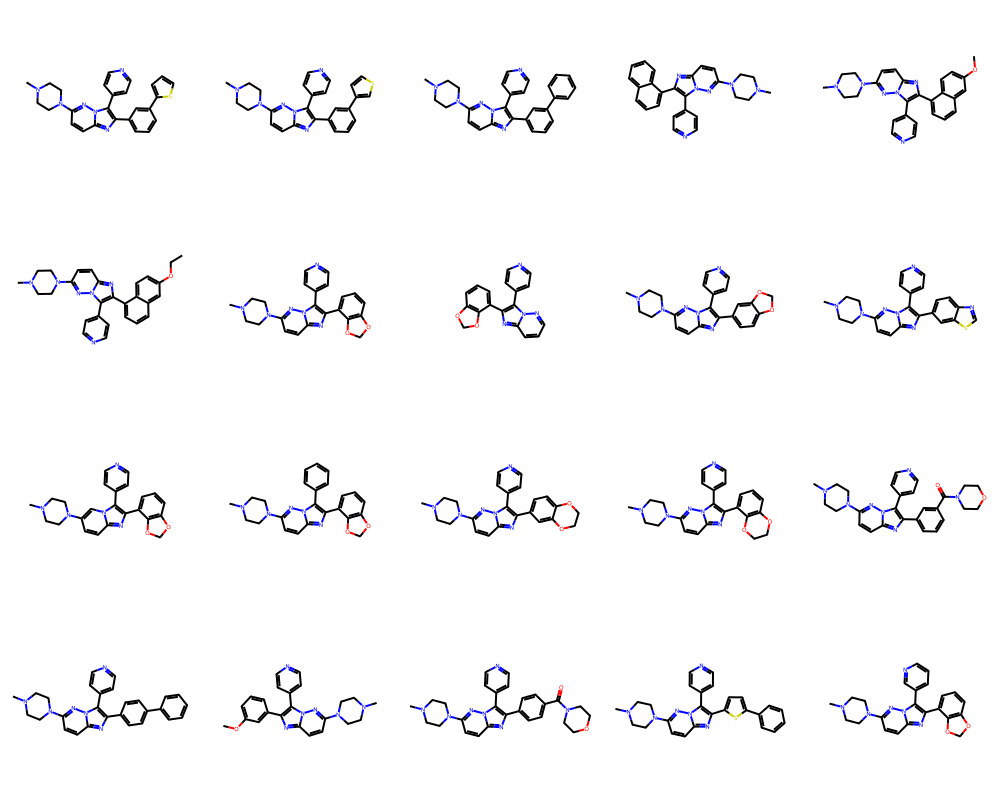

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
df = pd.read_csv('../data/genai/TL_reinvent_100.smi')
df.head(2)
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in df.smiles][:20], molsPerRow=5)

In [3]:
import subprocess

In [4]:
subprocess.call(
    ["/home/iwatobipen/miniforge3/envs/reinvent4/bin/reinvent", "-l", "TL.log", "../data/genai/transfer_learning.toml"]
)

|          |00:00
Epoch 300: |##########|01:53
0it [01:53, ?it/s]


0

#### 学習が終わったら tensroboard　でログを見てみましょう
- tensorboardはReinvent4と同じ環境下にいストールされています。

In [5]:
!/home/iwatobipen/miniforge3/envs/reinvent4/bin/tensorboard --logdir tb_TL/

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
E1008 20:47:56.772012 136645223384768 _internal.py:96] Error on request:
Traceback (most recent call last):
  File "/home/iwatobipen/miniforge3/envs/reinvent4/lib/python3.10/site-packages/werkzeug/serving.py", line 362, in run_wsgi
    execute(self.server.app)
  File "/home/iwatobipen/miniforge3/envs/reinvent4/lib/python3.10/site-packages/werkzeug/serving.py", line 323, in execute
    application_iter = app(environ, start_response)
  File "/home/iwatobipen/miniforge3/envs/reinvent4/lib/python3.10/site-packages/tensorboard/backend/application.py", line 528, in __call__
  

#### 訓練前後のモデルでサンプリング（構造生成）してみましょう

In [6]:
!cat ../data/genai/sampling.toml

# REINVENT4 TOML input example for sampling
#


run_type = "sampling"
device = "cuda:0"  # set torch device e.g. "cpu"
json_out_config = "_sampling.json"  # write this TOML to JSON


[parameters]

# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.

## Reinvent: de novo sampling
model_file = "/home/iwatobipen/dev/REINVENT4/priors/reinvent.prior"

## LibInvent: find R-groups for the given scaffolds
#model_file = "priors/libinvent.prior"
#smiles_file = "scaffolds.smi"  # 1 scaffold per line with attachment points

## LinkInvent: find a linker/scaffold to link two fragments
#model_file = "priors/linkinvent.prior"
#smiles_file = "warheads.smi"  # 2 warheads per line separated with '|'

## Mol2Mol: find molecules similar to the provided molecules
#model_file = "priors/mol2mol_medium_similarity.prior"
#smiles_file = "mol2mol.smi"  # 1 compound per line
#sample_strategy = "beamsearch"  # multinomial or beamsearch (

In [7]:
#訓練前のモデル
subprocess.call(
    ["/home/iwatobipen/miniforge3/envs/reinvent4/bin/reinvent", "-l", "sampling.log", "../data/genai/sampling.toml"]
)

0

In [8]:
#訓練後のモデル
subprocess.call(
    ["/home/iwatobipen/miniforge3/envs/reinvent4/bin/reinvent", "-l", "TL_sampling.log", "../data/genai/TL_sampling.toml"]
)

0

In [9]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

In [10]:
df1 = pd.read_csv('sampling.csv')
print(df1.shape)
df1.tail(2)

(156, 2)


,SMILES,NLL
154,CC12CCC3c4cc(Br)c(O)cc4CCC3C1CCC2=O,19.94
155,Cc1cccc(C)c1-n1c(C(C)N(CCC#N)C(=O)c2ccccc2)nc2...,30.65


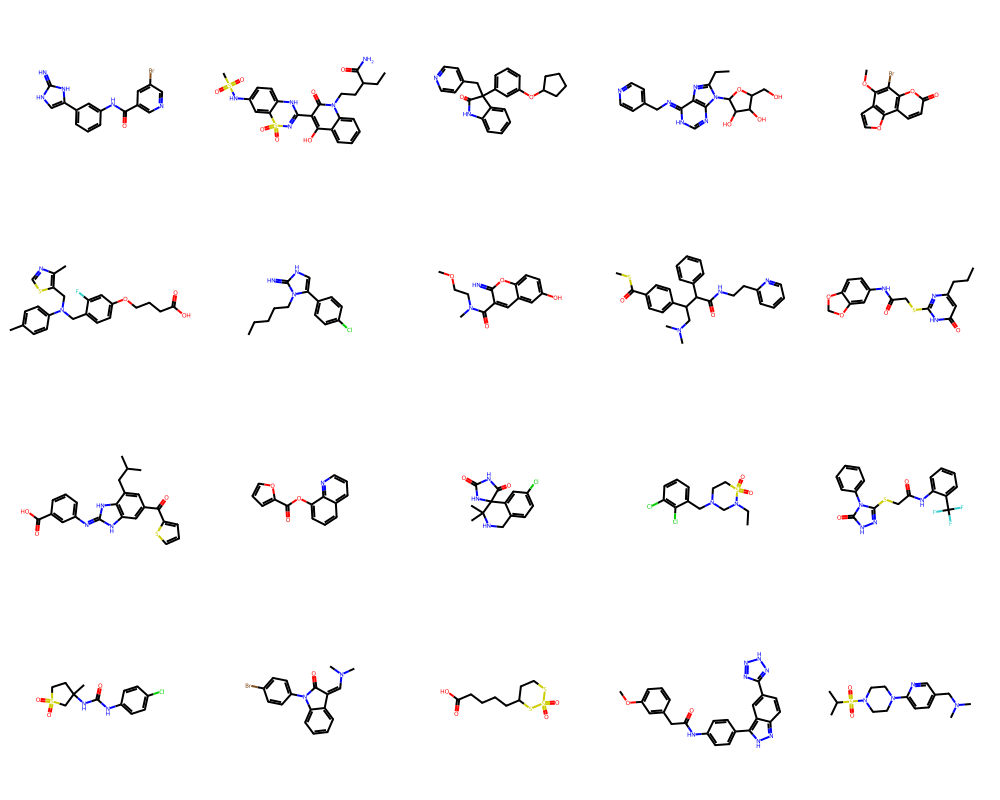

In [11]:
PandasTools.AddMoleculeColumnToFrame(df1, smilesCol='SMILES')
Draw.MolsToGridImage(df1.ROMol[:20], molsPerRow=5)

In [12]:
df2= pd.read_csv('TL_sampling.csv')
print(df2.shape)
df2.tail(2)

(104, 2)


,SMILES,NLL
102,COc1cc2c(Nc3ccc(Cl)c(Cl)c3F)ncnc2cc1OCC1CC2CN(...,17.25
103,COc1cc2c(Oc3ccc(NC(=O)C4CC(c5ccc6c(c5)OCO6)=NC...,22.61


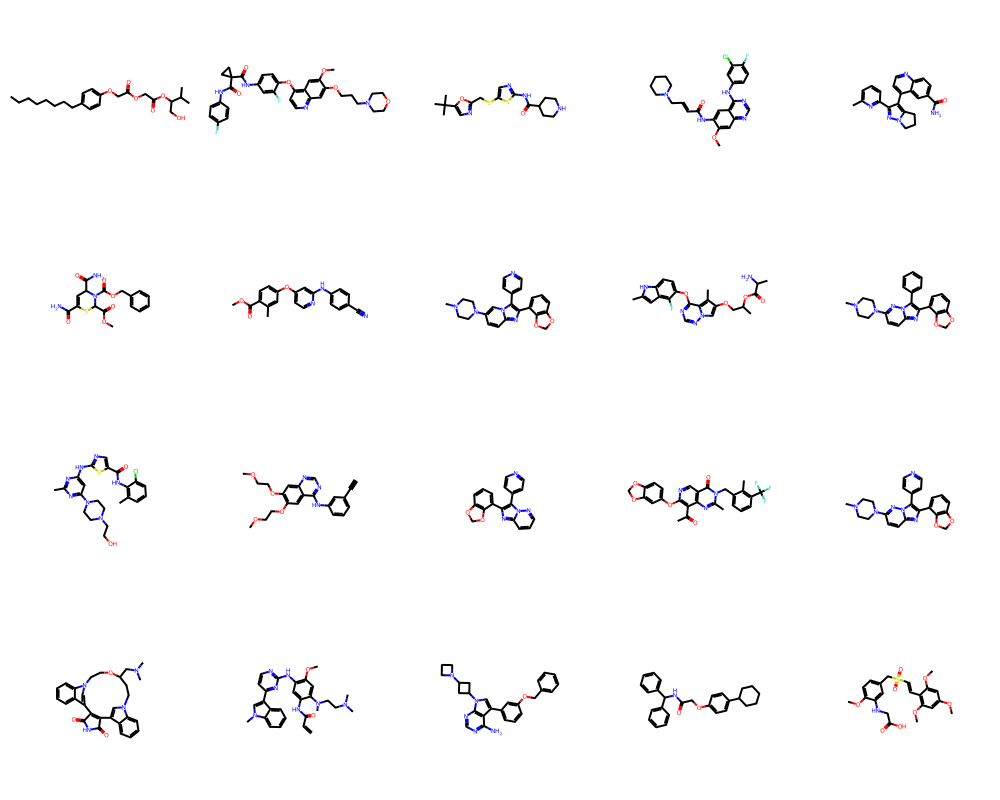

In [13]:
PandasTools.AddMoleculeColumnToFrame(df2, smilesCol='SMILES')
Draw.MolsToGridImage(df2.ROMol[:20], molsPerRow=5)

In [14]:
#### 転移学習後の分子は学習データに含まれるScaffoldを持つ構造も生成していそうです。